In [ ]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.colors as mcolors
import plotly.express as px

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:

#plt.ion()

In [ ]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 4873, 9999]

hypers = {
	'cma':['popsize','seed','sigma'],
	'pso':['popsize', 'w','seed', 'c1', 'c2'],
	'bo-ucb':['seed','kappa'],
	'bo-ei': ['seed','xi'],
	'bo-poi': ['seed','xi']
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

In [ ]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

In [ ]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

In [ ]:
def drawParetoPlot(*args, **kwargs):
	df = kwargs.pop('data').copy(deep=True)

	method = df['method'].iat[0]
	progname = df['progname'].iat[0]
	probsize = df['probsize'].iat[0]

	cols = hypers[method]
	#print('cols', cols)

	colsToKeep = cols+['globalSample', 'xtime']
	df = df[colsToKeep]

	df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

	#print('dropped cols')
	#print(df.head())

	# need to make one column with the cummax and grab the 300th step
	df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')

	#print('pre new index')
	#print(df.head())

	# rescale the xtime to be baseline-normalized
	df = df.set_index(cols)

	# do the baseline normalization here
	baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = baselineXtime/optimalXtime

	df['baselineXtime'] = baselineXtime/df['cummin']

	#print(f'{method} {progname} {probsize}')
	#print(df.head())

	# now make a new df with just the unique values of the hyperparam columns
	# the 'baselineXtime' column will be the max speedup we get after 300 steps
	#toplot = df[df['globalSample'] == 299.0]

	earliestSamples = pd.DataFrame(index=df.index.copy())
	earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
	earliestSamples['firstSample'] = 301
	earliestSamples['maxSpeedup'] = 0

	# now for each index, find the earliest globalSample that is greater than 1.0
	#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
	firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
	maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

	earliestSamples['firstSample'].update(firstSamp)
	earliestSamples['maxSpeedup'].update(maxSpeed)
	#earliestSamples = earliestSamples.reset_index()

	# drop the configurations that never reach the baseline
	#earliestSamples = earliestSamples.dropna(how='any')

	#print('earliestSamples')
	#print(earliestSamples.head())
	#print(earliestSamples.tail())


	#ax = plt.gca()
	
	ax = sns.scatterplot(earliestSamples, x='maxSpeedup', y='firstSample')

	ax.set_xlabel('Max Speedup after 300 steps')
	ax.set_ylabel('Earliest Timestep Surpassing Baseline Execution Time')
	ax.axvline(1.0, label='Baseline Speedup', zorder=0, c='red')
	ax.axvline(optimalXtime, label='Optimal Speedup', zorder=0, c='blue')
	#ax.legend()
	#ax.set_ylim(0, 302)
	ax.set_xlim(0.99, optimalXtime+(0.02*optimalXtime))

	return

def makeParetoPlots(df, progname):
	#print(df.shape)
	#print(df.columns)

	df = df[df['progname'] == progname].reset_index(drop=True)

	#print(df.shape)
	#print(df.columns)

	g = sns.FacetGrid(df, row='method', col='probsize', col_order=probsizes, height=10, aspect=1.5, sharex=False, sharey=False)
	g.map_dataframe(drawParetoPlot, annot=True, xticklabels=True, yticklabels=True)
	
	for ax in g.axes.flatten():
		#ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
		ax.legend(loc='best')
	
	#plt.tight_layout()
	g.set_titles(col_template="Problem Size: {col_name}", row_template="GO Method: {row_name}")
	
	g.fig.subplots_adjust(top=0.96)
	g.fig.suptitle(f'GO Hyperparam Comparison ({progname.upper()})')
	
	plt.show()
	

	return

In [ ]:
#makeParetoPlots(overallDF, 'bt_nas')
#makeParetoPlots(overallDF, 'ft_nas')
#makeParetoPlots(overallDF, 'hpcg')
#makeParetoPlots(overallDF, 'lulesh')

In [ ]:
# now let's make the same plots in plotly


In [ ]:
print(overallDF.columns)
print(overallDF.shape)

gomethods = list(hypers.keys())
print(gomethods)

In [ ]:
def tupleizeCols(df, cols):
	newColName = f'({",".join([str(col) for col in cols])})'
	df[newColName] = pd.Categorical(list(zip(*[df[col] for col in cols])))
	#df['code'] = df[newColName].cat.codes
	df = df.drop(cols, axis=1)
	return df, newColName

def fix_fig(fig, labels):
	fig.for_each_xaxis(lambda x: x.update(title = ''))
	fig.add_annotation(x=0.5,y=-0.2,
              text=labels['maxSpeedup'],
               xref="paper", yref="paper")
	fig.for_each_yaxis(lambda y: y.update(title = ''))
	fig.add_annotation(x=-0.05,y=0.5, 
              text=labels['firstSample'], textangle=-90,
               xref="paper", yref="paper")
	fig.show()
	return

In [ ]:
def doPlotlyPlots(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)


			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']

			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()

			labels = {
				'firstSample': 'Earliest Timestep Surpassing Baseline Execution Time',
				'maxSpeedup': 'Max Speedup after 300 steps'
			}
			width = 900
			height = 400
			palette = 'BlueRed'
			#if method == 'pso':
			#	earliestSamples, newColName = tupleizeCols(earliestSamples, ['w', 'c1', 'c2'])
			#	newColName = 'code'
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='popsize', color=newColName, color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'cma':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
			#									 z='popsize', color='sigma', color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ei':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-poi':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}', 
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ucb':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='kappa', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)

			if method == 'pso':
				#earliestSamples, newXCol = tupleizeCols(earliestSamples, ['popsize', 'w'])
				#earliestSamples, newYCol = tupleizeCols(earliestSamples, ['c1', 'c2'])

				#fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
				#								 facet_col=newXCol, facet_row=newYCol, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
				#								 title=f'{progname}-{probsize}-{method}',
				#								 hover_data=list(earliestSamples.columns), width=1000, height=1000)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='popsize', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='w', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c1', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c2', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'cma':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
												 facet_col='popsize', color='sigma', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=500)
			elif method == 'bo-ei':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-poi':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}', 
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-ucb':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='kappa', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)

			fix_fig(fig, labels)

In [ ]:
#doPlotlyPlots(overallDF, 'bt_nas')
#doPlotlyPlots(overallDF, 'hpcg')
#doPlotlyPlots(overallDF, 'ft_nas')
#doPlotlyPlots(overallDF, 'lulesh')

In [65]:
# now let's take the top 10% of configurations 
# the criteria for selecting the top 10% is their euclidean distance
# of: (((300stepMaxSpeedup - optimalSpeedup)/optimalSpeedup)^2 + ((earliestTimestep-0)/299)^2)^(1/2)
# 

colormap = dict(zip(seeds, ['red', 'orange', 'green', 'blue']))

def plotTopPoints(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		top10s = pd.DataFrame()
		bot10s = pd.DataFrame()
		newColName = ''

		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

			# drop all the first samples, as they're random
			df = df[df['globalSample'] != 0.0 ]

			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']


			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()
			# now let's make the distance metric column
			#earliestSamples['score'] = (((earliestSamples['maxSpeedup'] - optimalXtime)/optimalXtime)**2 + (earliestSamples['firstSample']/299)**2)**(1/2)
			earliestSamples['score'] = earliestSamples['maxSpeedup']*0.5  + 0.5*(1/earliestSamples['firstSample'])

			# drop any samples with a score of exactly 0 -- meaning they found the
			# optimal on the first sample (i.e: a lucky sampling...)
			# earliestSamples = earliestSamples[earliestSamples.score != 0.0]

			# create a cutoff score, we keep scores smaller than this
			#cutoff_score = (((1-optimalXtime)/optimalXtime)**2 + (49/300)**2)**(1/2)

			#earliestSamples = earliestSamples[earliestSamples.score < cutoff_score]

			# now cut down on the samples and only show the top 10 configurations 
			earliestSamples = earliestSamples.sort_values(by=['score'], ascending=False)
			earliestSamples = earliestSamples.drop(['maxSpeedup', 'firstSample'], axis=1)

			earliestSamples = earliestSamples.reset_index(drop=True)

			targetCols = list(earliestSamples.columns)
			targetCols.remove('score')
			targetCols.remove('seed')
			#print('targetCols', targetCols)

			#print(earliestSamples.head())

			# groupby the targetCols, and average the 'scores' across the four seeds of each config to the pick the 10 best and worst
			# performing configurations (on average).
			avrgSeeds = earliestSamples.groupby(targetCols, as_index=False)['score'].mean().reset_index(drop=True)
			#avrgSeeds = avrgSeeds.drop(['seed'], axis=1)
			avrgSeeds = avrgSeeds.sort_values(by=['score'], ascending=False)

			
			tenTOP = avrgSeeds.head(10) #pd.concat([avrgSeeds.head(10), avrgSeeds.tail(10)], ignore_index=True)
			tenBOT = avrgSeeds.tail(10) #pd.concat([avrgSeeds.head(10), avrgSeeds.tail(10)], ignore_index=True)

			# the ten best and worst
			# tenBW = pd.concat([earliestSamples.head(10), earliestSamples.tail(10)], ignore_index=True)

			allSeedsTOP = earliestSamples[earliestSamples.set_index(targetCols, drop=True).index.isin(tenTOP.set_index(targetCols, drop=True).index)]
			allSeedsBOT = earliestSamples[earliestSamples.set_index(targetCols, drop=True).index.isin(tenBOT.set_index(targetCols, drop=True).index)]

			allSeedsTOP = allSeedsTOP.reset_index(drop=True)
			allSeedsBOT = allSeedsBOT.reset_index(drop=True)

			meanscoreTOP = allSeedsTOP.groupby(targetCols)['score'].mean()
			meanscoreBOT = allSeedsBOT.groupby(targetCols)['score'].mean()

			allSeedsTOP = allSeedsTOP.set_index(targetCols)
			allSeedsBOT = allSeedsBOT.set_index(targetCols)

			allSeedsTOP['meanscore'] = meanscoreTOP
			allSeedsBOT['meanscore'] = meanscoreBOT

			allSeedsTOP = allSeedsTOP.reset_index()
			allSeedsBOT = allSeedsBOT.reset_index()

			#allSeeds = allSeeds.sort_values(by=targetCols+['score'])
			#allSeeds = allSeeds.sort_values(by=['meanscore'], ascending=False)

			allSeedsTOP, newColName = tupleizeCols(allSeedsTOP, targetCols)
			allSeedsTOP['probsize'] = probsize
			top10s = pd.concat([top10s, allSeedsTOP], ignore_index=True)

			allSeedsBOT, newColName = tupleizeCols(allSeedsBOT, targetCols)
			allSeedsBOT['probsize'] = probsize
			bot10s = pd.concat([bot10s, allSeedsBOT], ignore_index=True)

		# now take the top 10s and plot them
		print(f'{progname} {method} \n')#, top10s)

		# we're gonna make a bar plot where the bars go from left to right
		# then we're gonna add annotations that show what each is
		def makeSubPlot(*args, **kwargs):
			data = kwargs.pop('data')

			#data = data.drop(['firstSample', 'maxSpeedup'], axis=1)
			data.loc[:,'score'] = data.score.round(5)
			data.loc[:,'meanscore'] = data.meanscore.round(4)
			#ax = sns.scatterplot(data, x=0, y='score')

			data = data.drop(['probsize'], axis=1)
			data.seed = data.seed.astype('category')

			#print('data\n', data.dtypes, '\n', data.pivot(index=newColName, columns='seed', values='score'))

			#data.set_index(newColName).plot(kind='barh', y='score', stacked=True, ax=plt.gca())
			#data.set_index(newColName).plot(kind='barh', y='score', stacked=True, alpha=0.25, ax=plt.gca())
			##data.set_index(newColName).plot(kind='barh', y='score', stacked=True, alpha=0.25, ax=plt.gca())

			#data.pivot(index=newColName, columns='seed', values='score').plot(kind='barh', stacked=True, ax=plt.gca())
			data.pivot(index=['meanscore', newColName], columns='seed', values='score').plot(kind='barh', stacked=False, ax=plt.gca())

			# this works for single bar representation
			#yelems = list(data[newColName].unique())
			#for index, elem in enumerate(yelems):
			#	subdata = data[data[newColName] == elem]
			#	subdata = subdata.sort_values(by=['score'], ascending=False)
			#	for seed in list(subdata.seed.unique()):
			#		subsubdata = subdata[subdata.seed == seed]
			#		subsubdata = subsubdata.drop(['seed'], axis=1)
			#		plt.barh(y=index, width=subsubdata.score, label=str(seed), color=colormap[seed])

			ax = plt.gca()
			#ax.set_yticks(list(range(len(yelems))))
			#ax.set_yticklabels(yelems)
			#ax.set_ylabel(newColName)
			ax.set_xlabel('Score')

			# this works for bar plot -- but colors get muddled
			#colormap = dict(zip(seeds, ['red', 'orange', 'green', 'blue']))
			## for each seed, we're going to make a barplot
			#for seed in list(data.seed.unique()):
			#	subdata = data[data.seed == seed]
			#	print(subdata)
			#	subdata = subdata.drop(['seed'], axis=1)
			#	#ax = sns.barplot(subdata, x='score', y=newColName, label=str(seed), alpha=0.25)
			#	subdata.set_index(newColName).plot(kind='barh', y='score', label=str(seed), color=colormap[seed], alpha=0.25, ax=plt.gca())

				#for bar in ax.containers[0]:
				#	bar.set_alpha(0.1)
					
			# for each datapoint, lets annotate
			#for index, row in data.iterrows():
				#annot = str(row.to_dict())
				#ax.annotate(annot, xy=(0, row['score']), xytext=(-20,20), 
				#		textcoords='offset points', ha='center', va='bottom',
				#		bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
				#		arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
				
				

			return

		top10s['top'] = True
		bot10s['top'] = False

		joined = pd.concat([top10s, bot10s], ignore_index=True).drop_duplicates([newColName,'meanscore','seed'])

		g = sns.FacetGrid(joined, col='probsize', sharex=False, sharey=False, height=6, aspect=0.8)
		g.map_dataframe(makeSubPlot)

		g.fig.subplots_adjust(top=0.85)
		g.fig.suptitle(f'{progname} {method}')
		
		#lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='seed', reverse=True)

		ax = plt.gca()
		handles, labels = ax.get_legend_handles_labels()
		unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
		unique = sorted(unique, key=lambda x: x[1], reverse=True)
		ax.legend(*zip(*unique), bbox_to_anchor=(1.05, 1), loc=2, title='seed', reverse=True)


		plt.show()

			
	return

bt_nas cma 



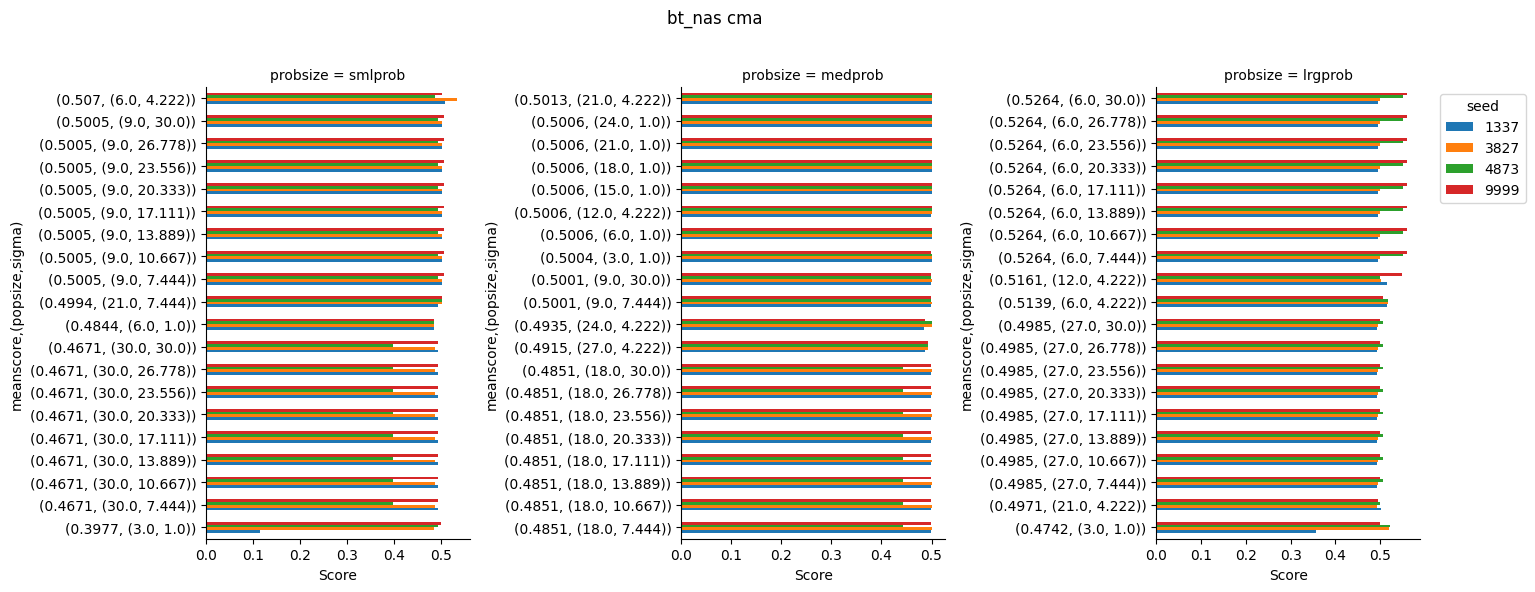

bt_nas pso 



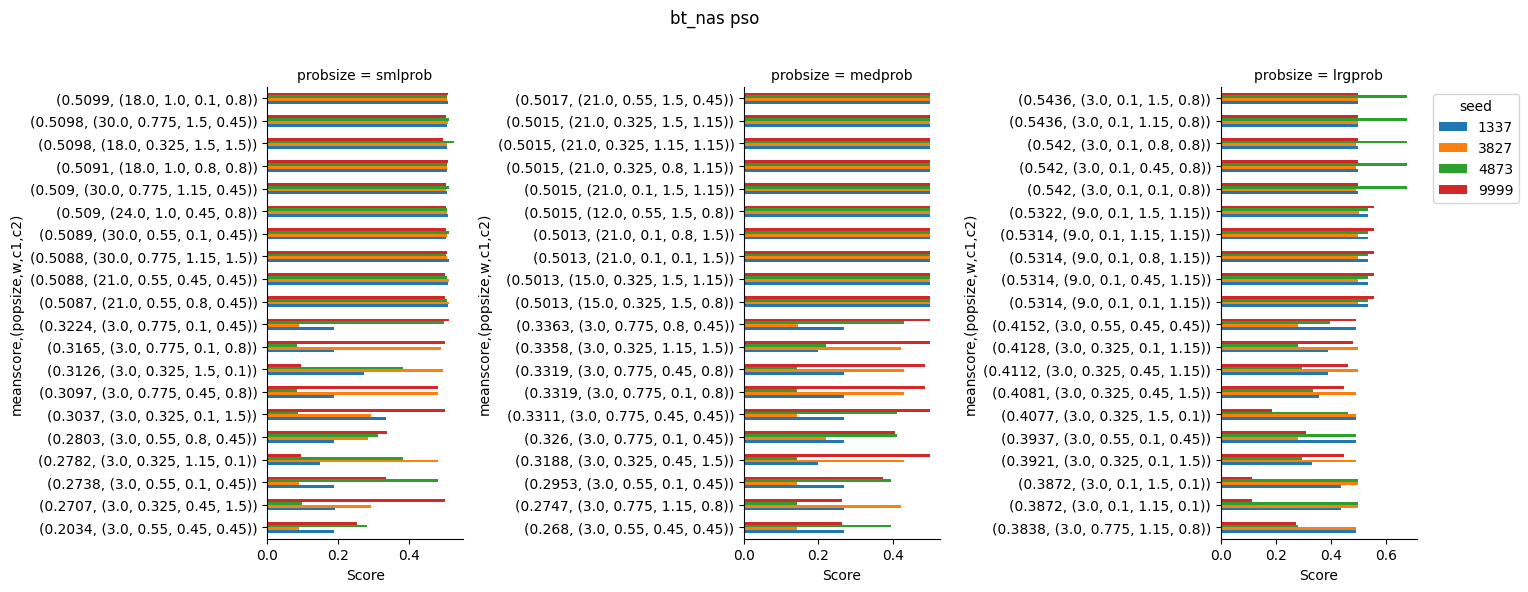

bt_nas bo-ucb 



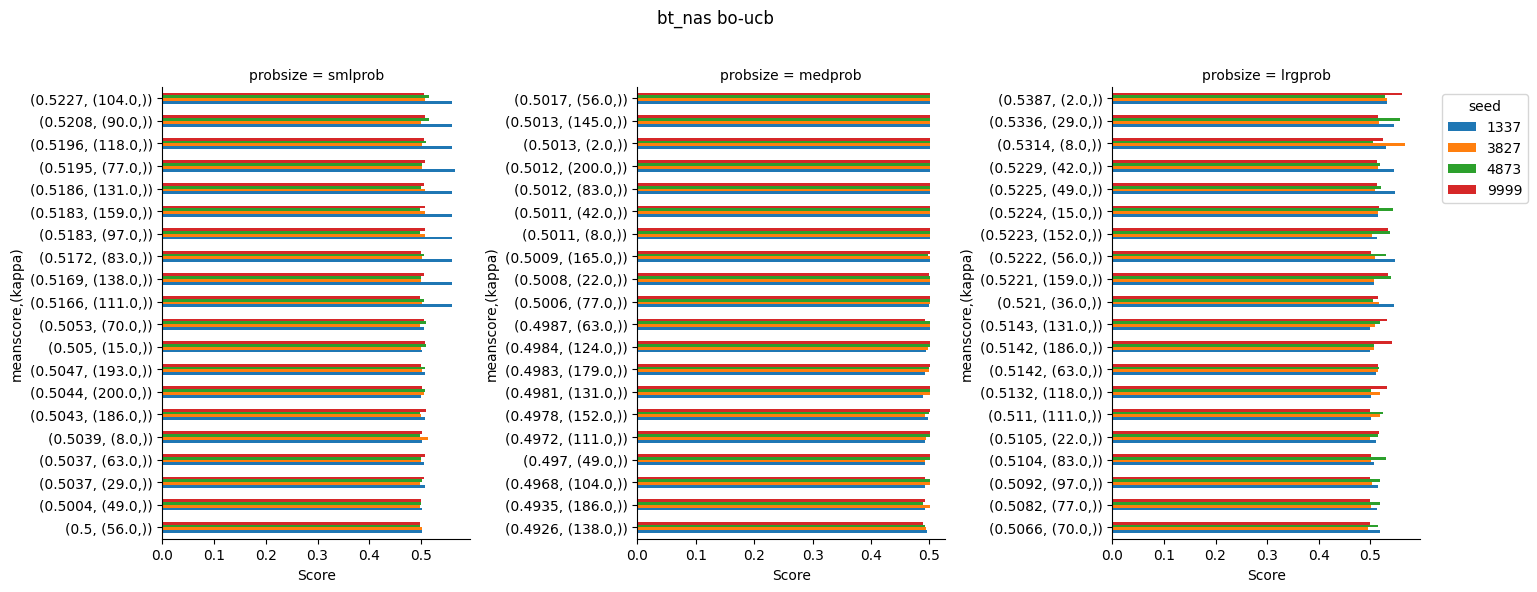

bt_nas bo-ei 



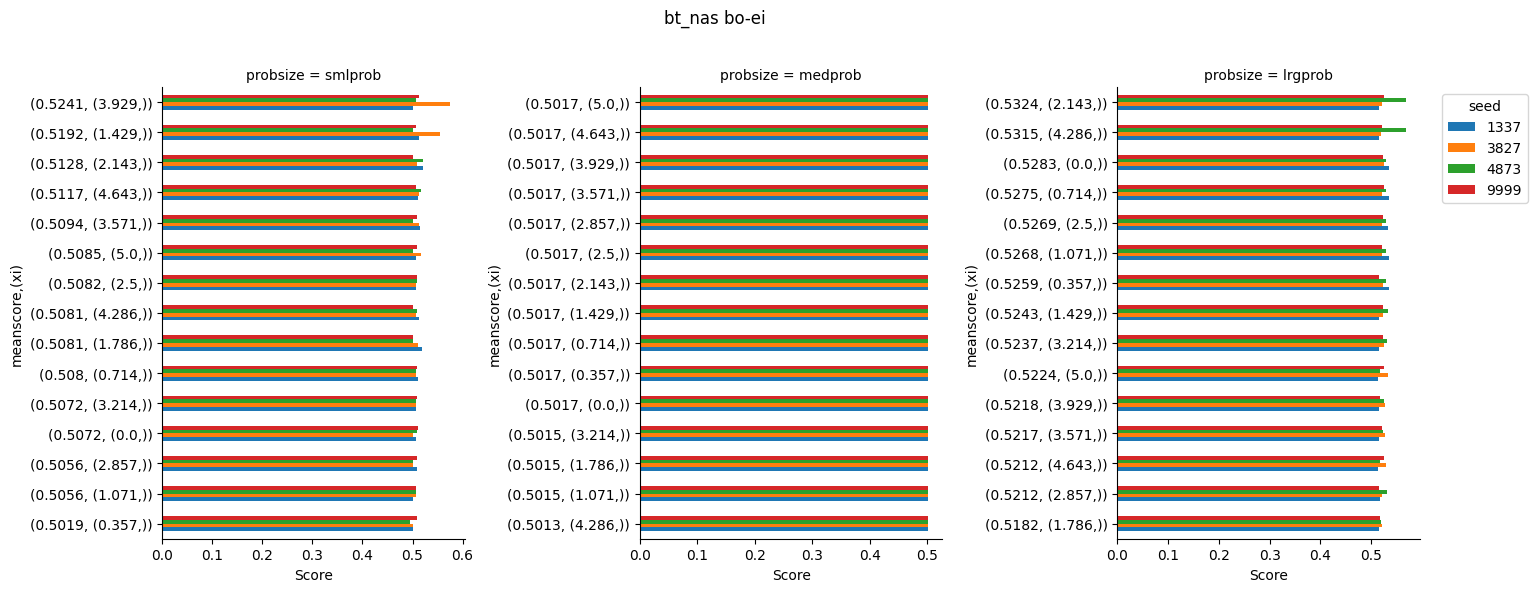

bt_nas bo-poi 



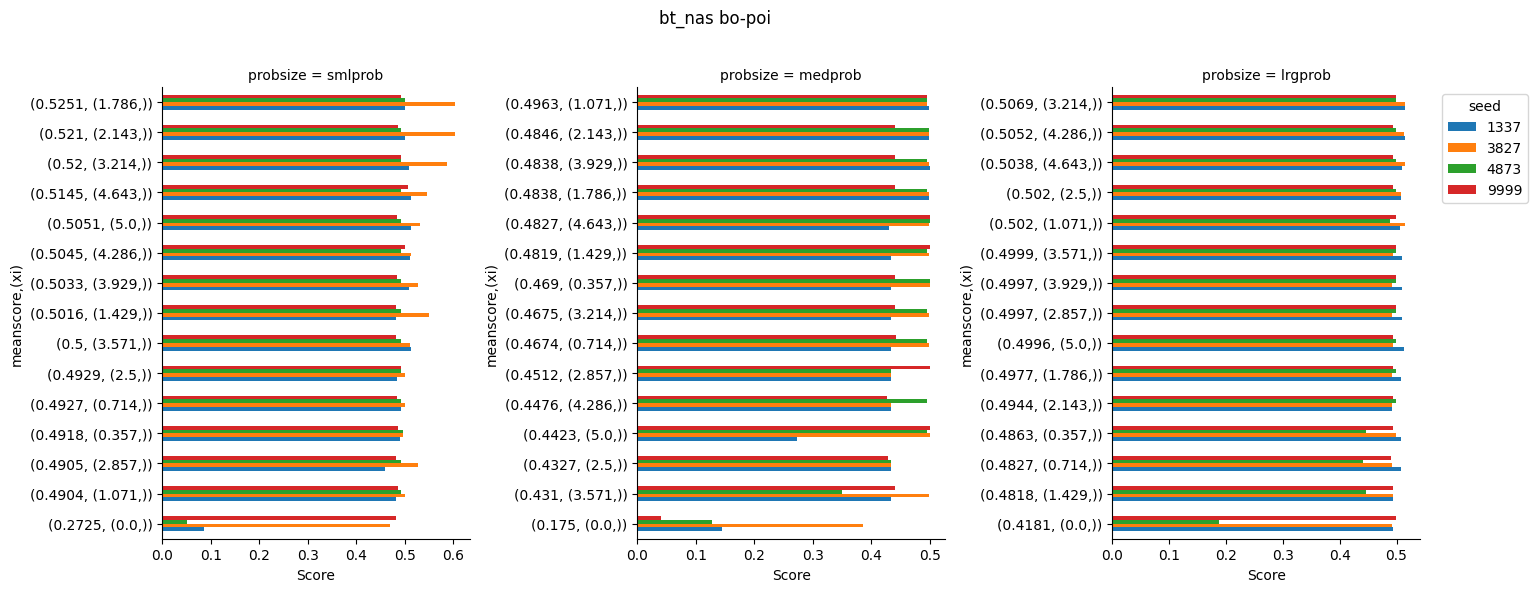

hpcg cma 



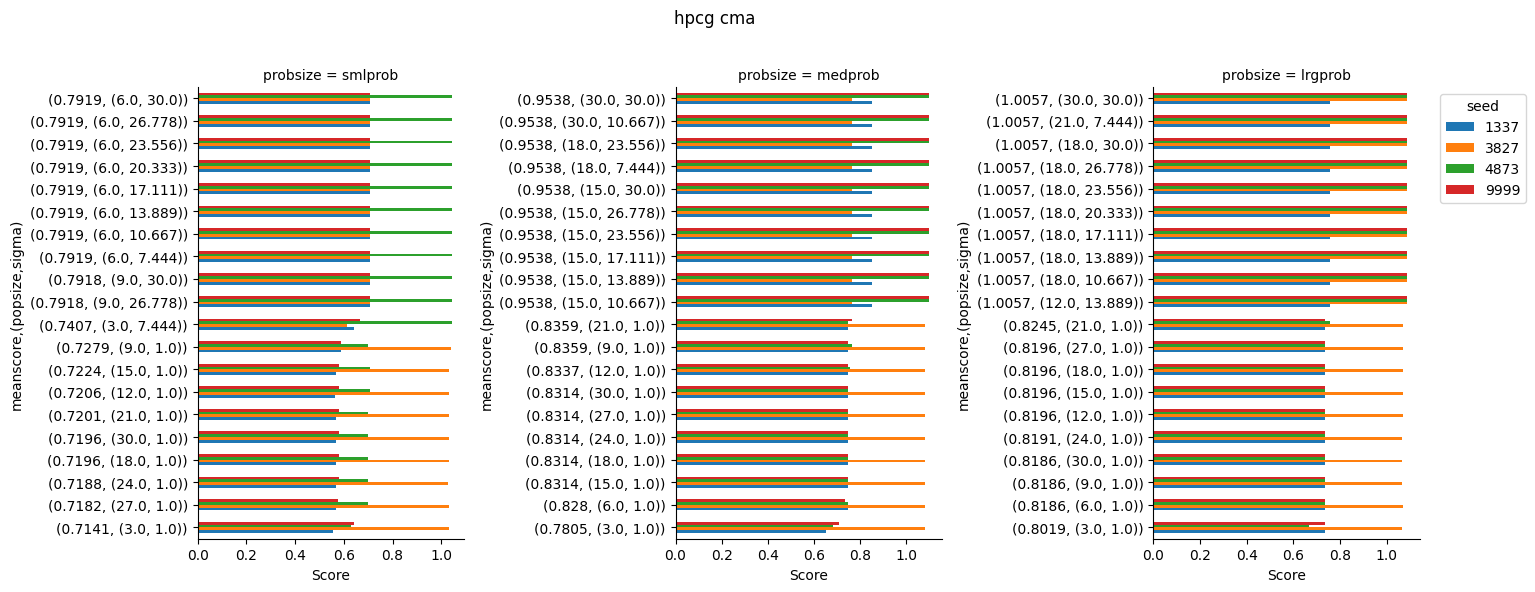

hpcg pso 



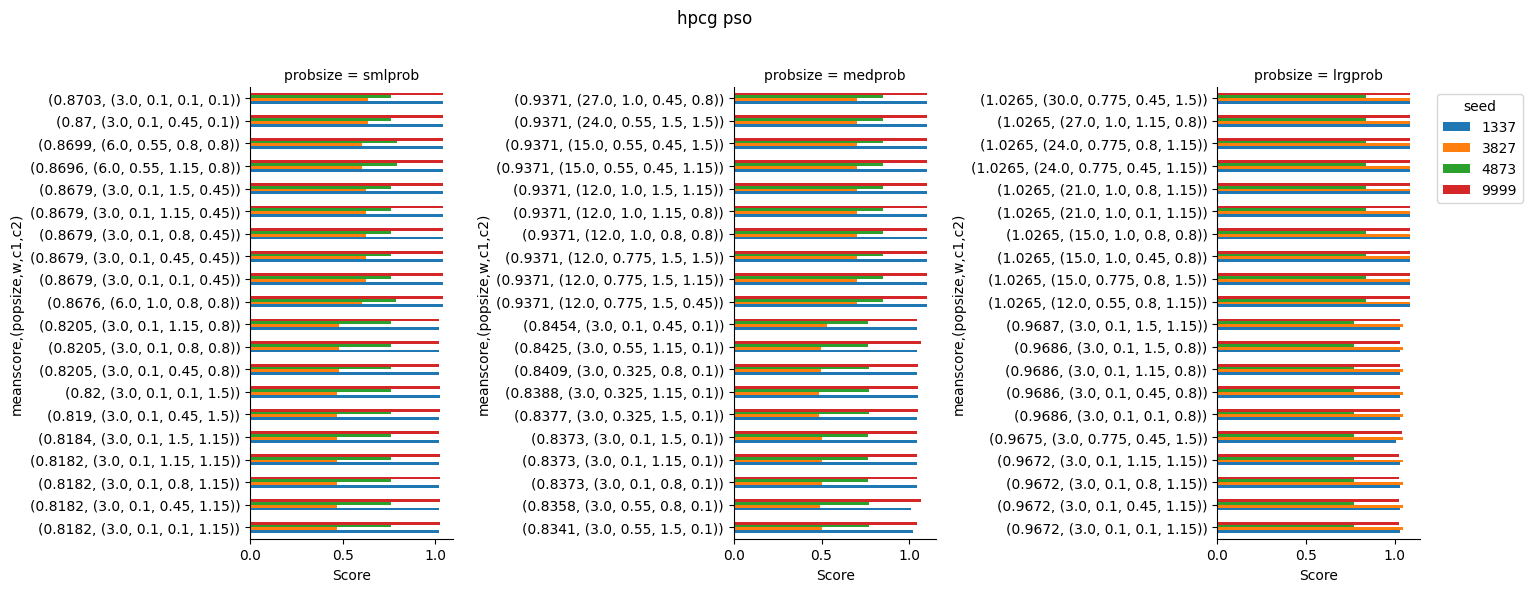

hpcg bo-ucb 



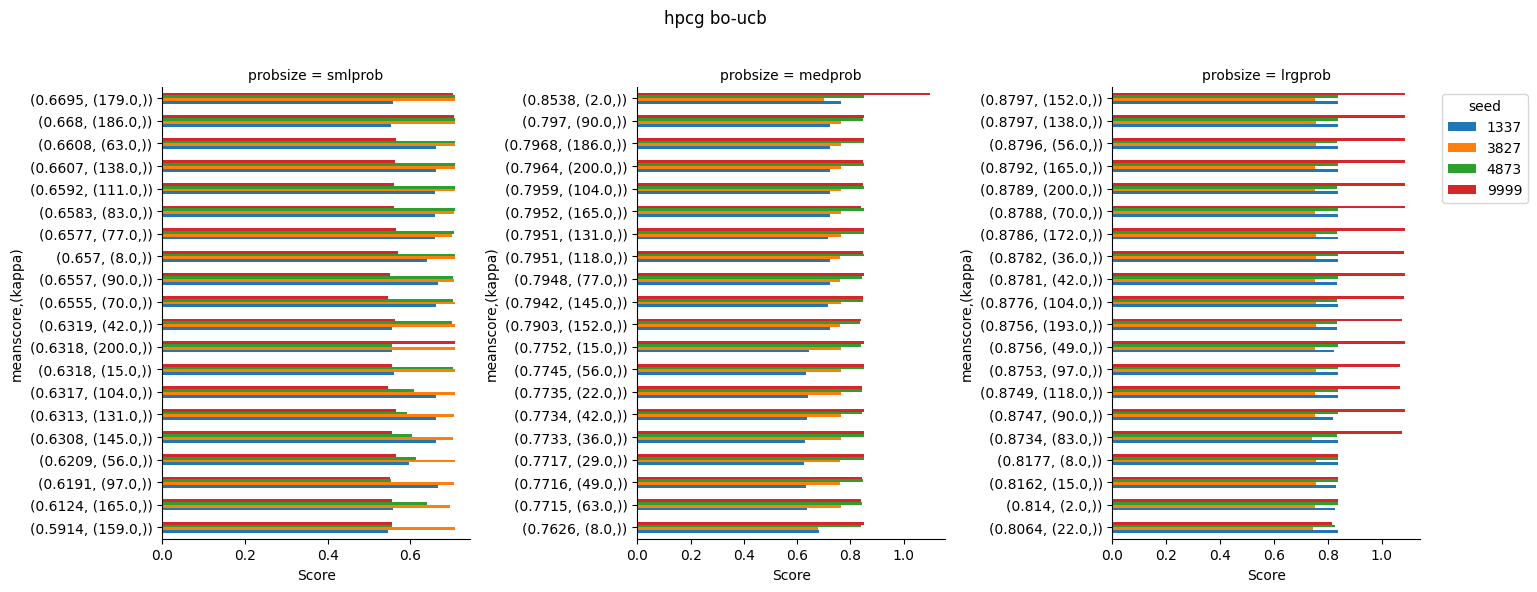

hpcg bo-ei 



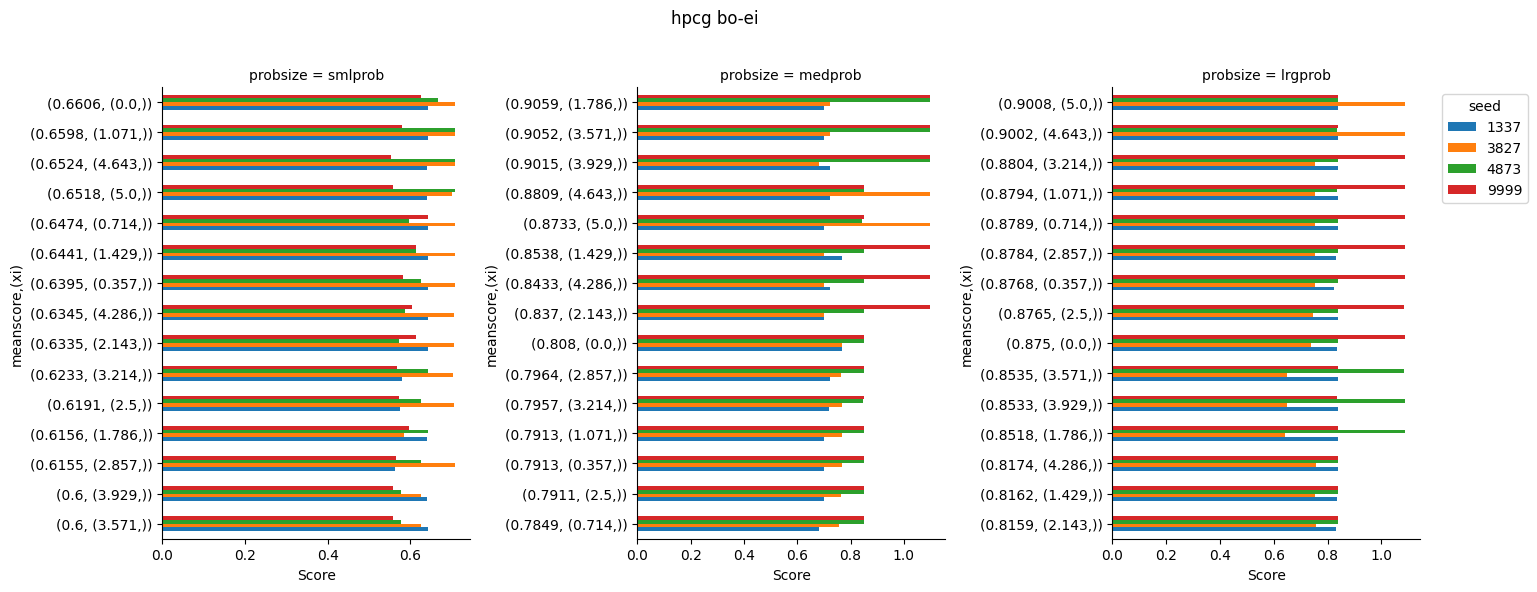

hpcg bo-poi 



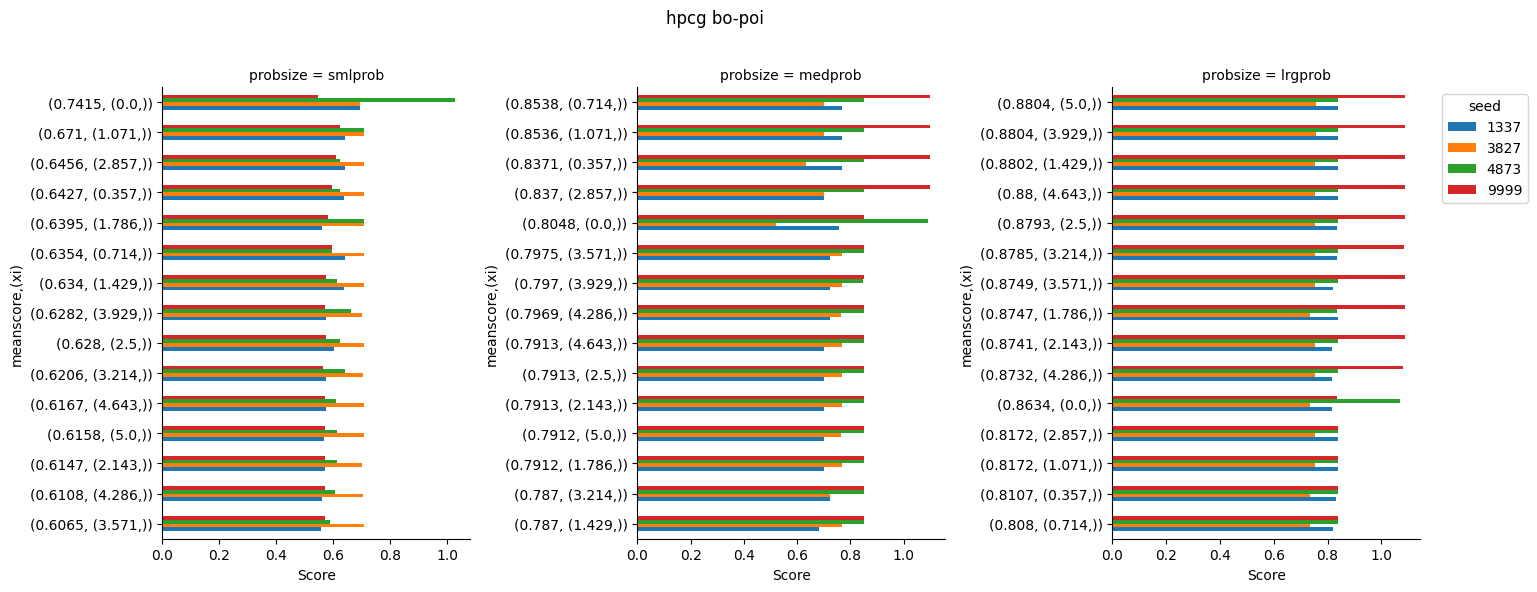

ft_nas cma 



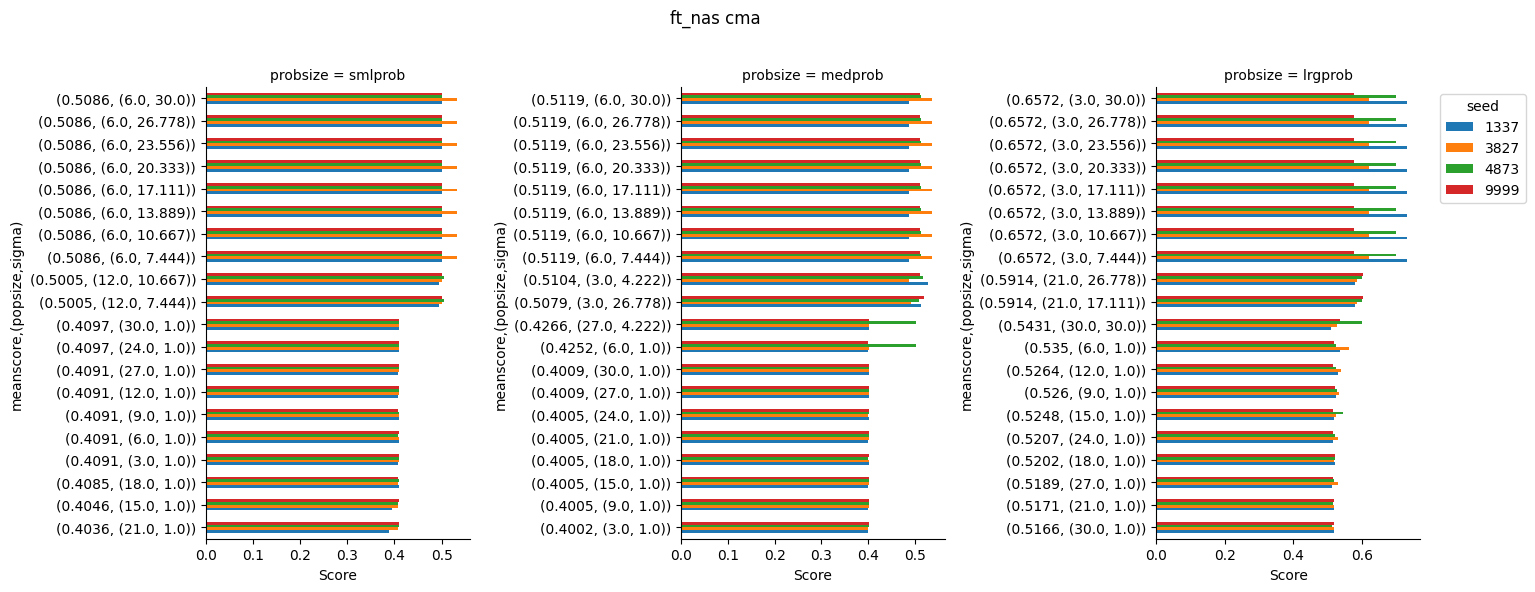

ft_nas pso 



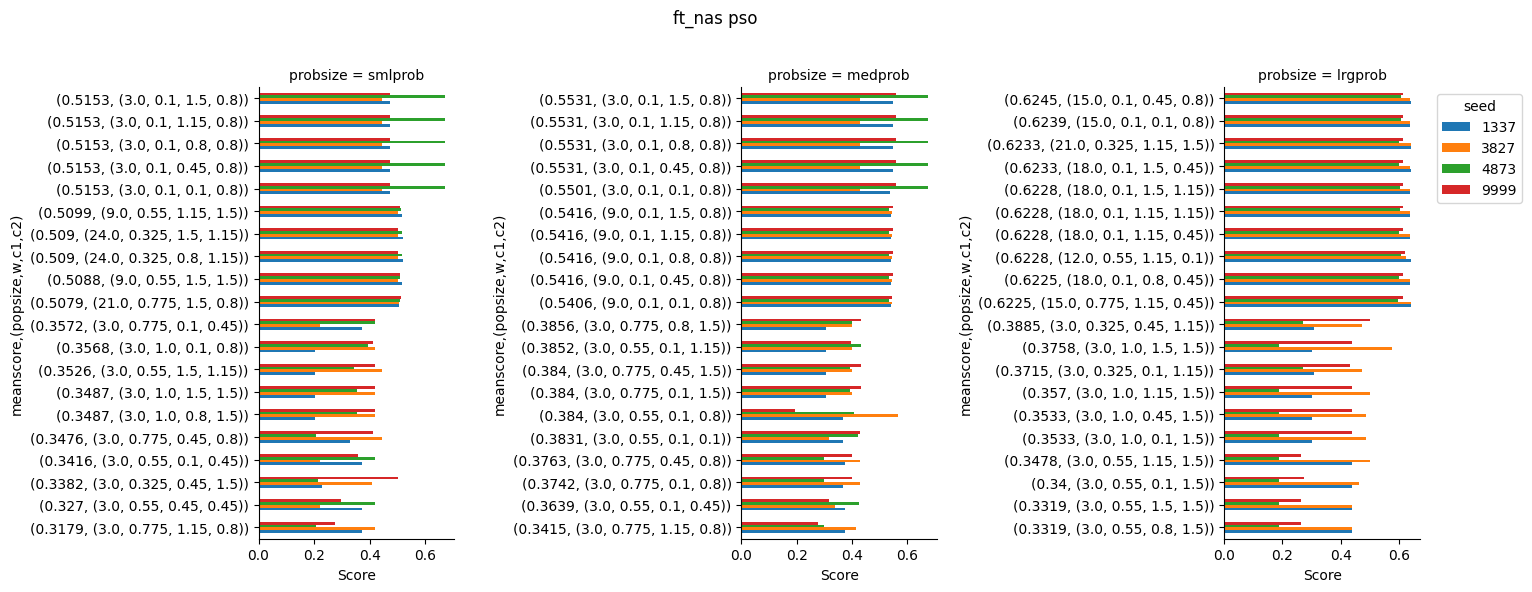

ft_nas bo-ucb 



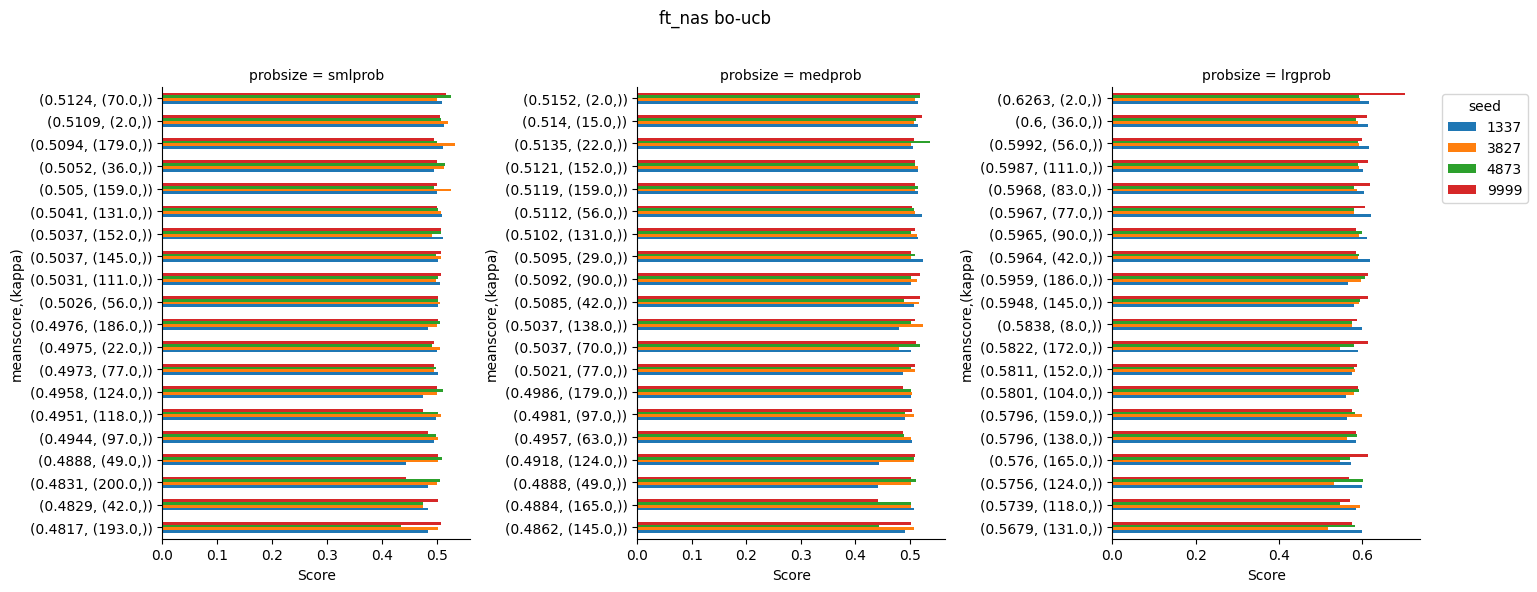

ft_nas bo-ei 



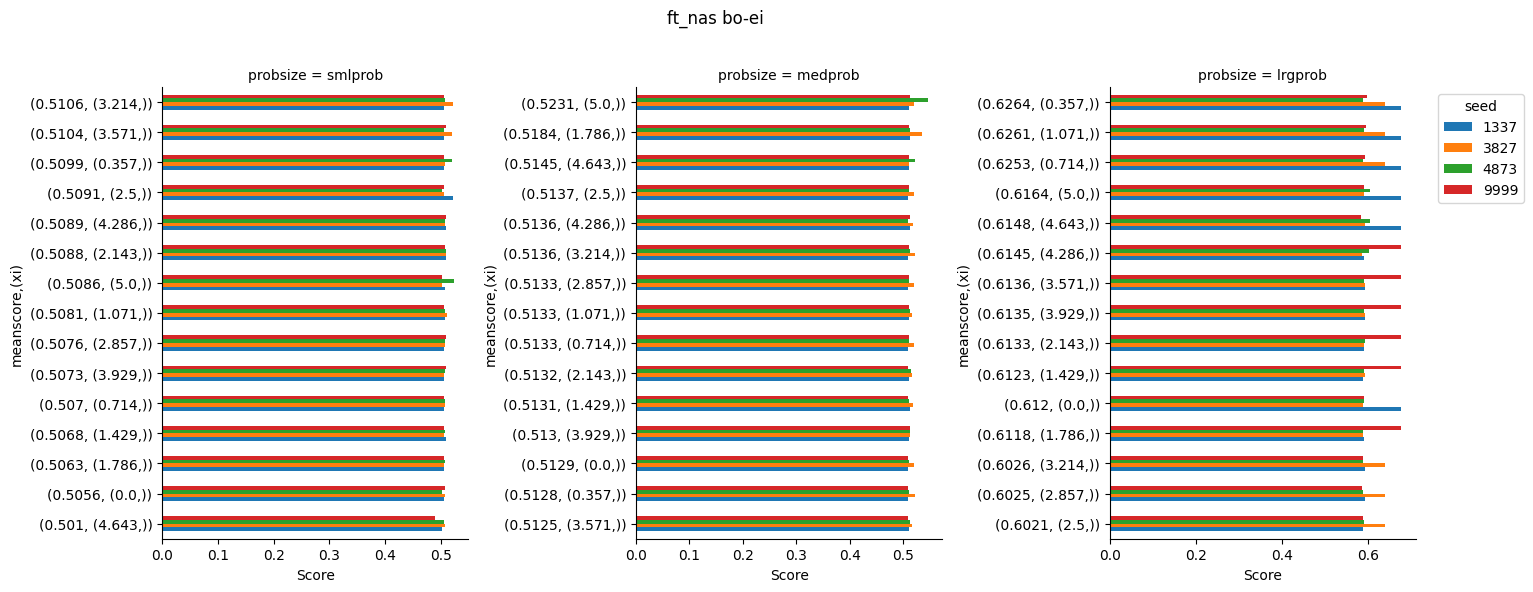

ft_nas bo-poi 



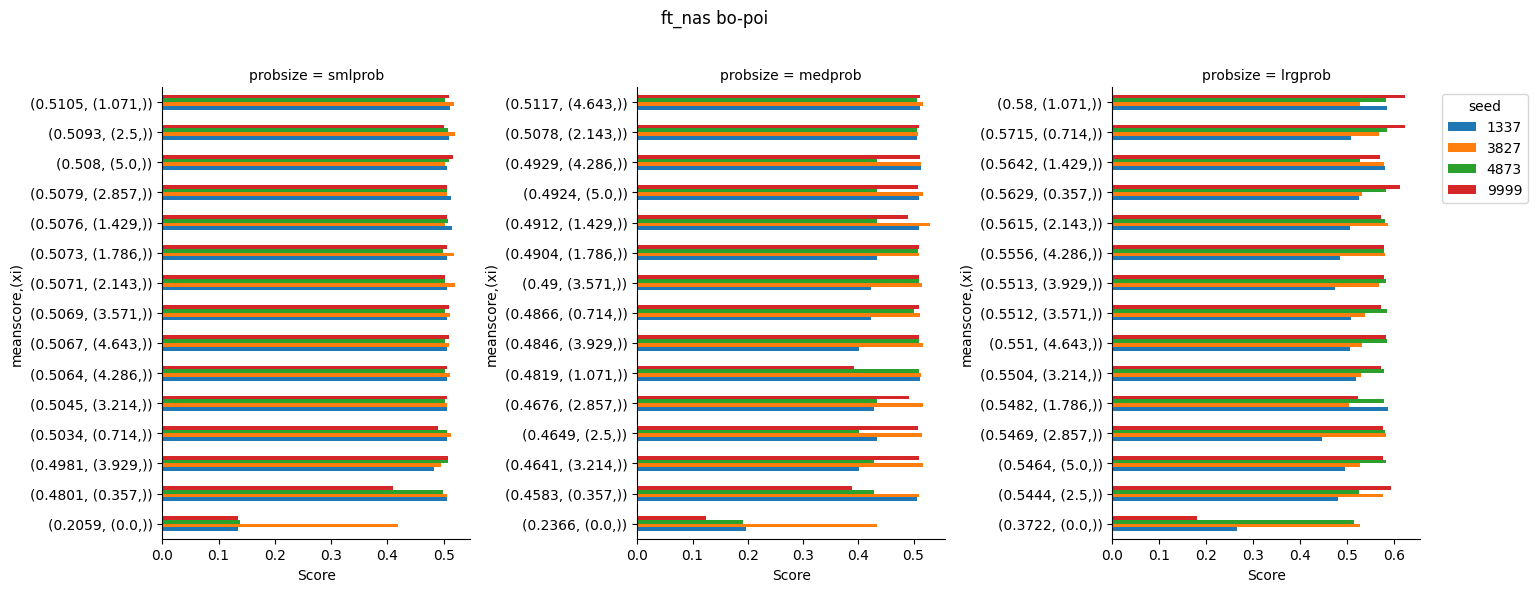

lulesh cma 



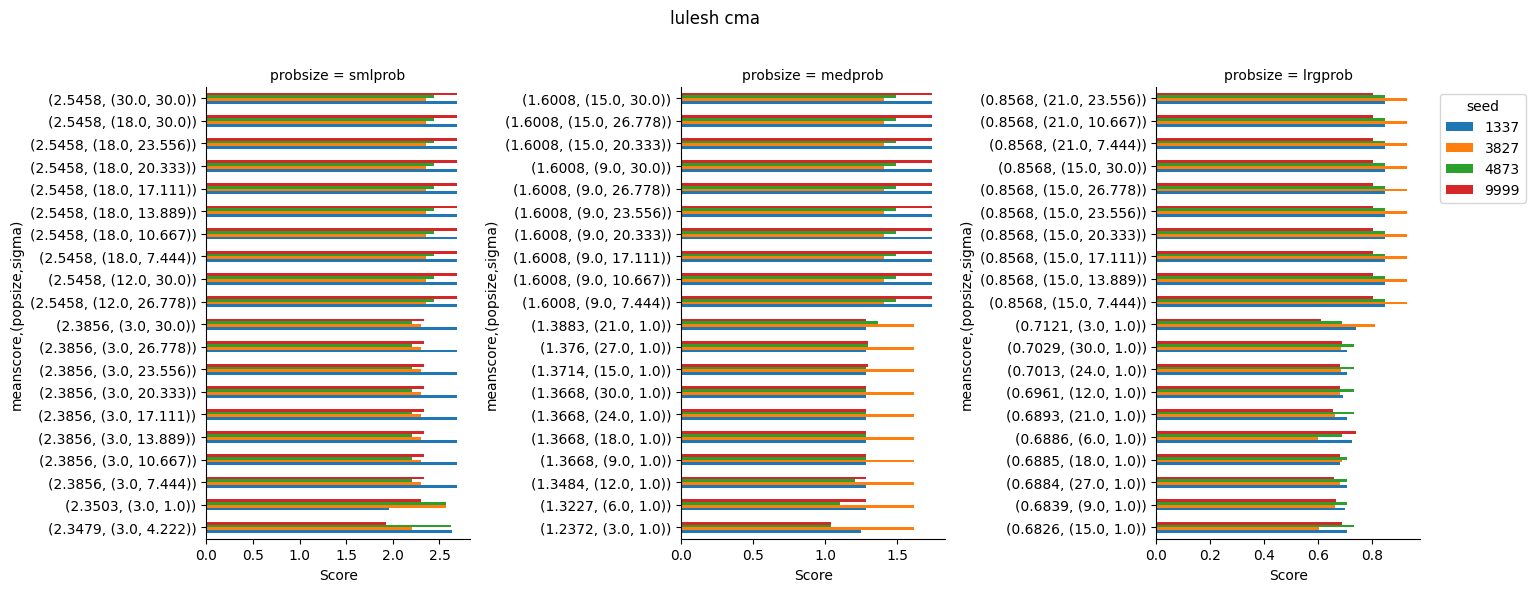

lulesh pso 



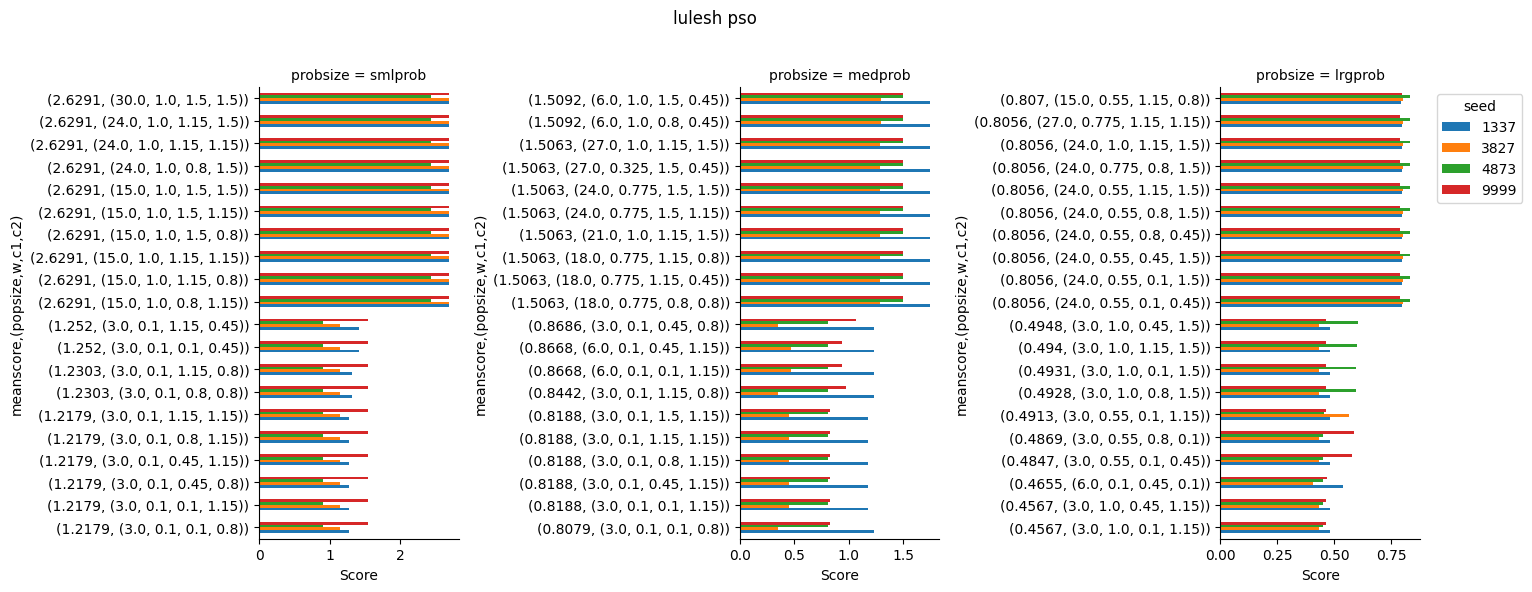

lulesh bo-ucb 



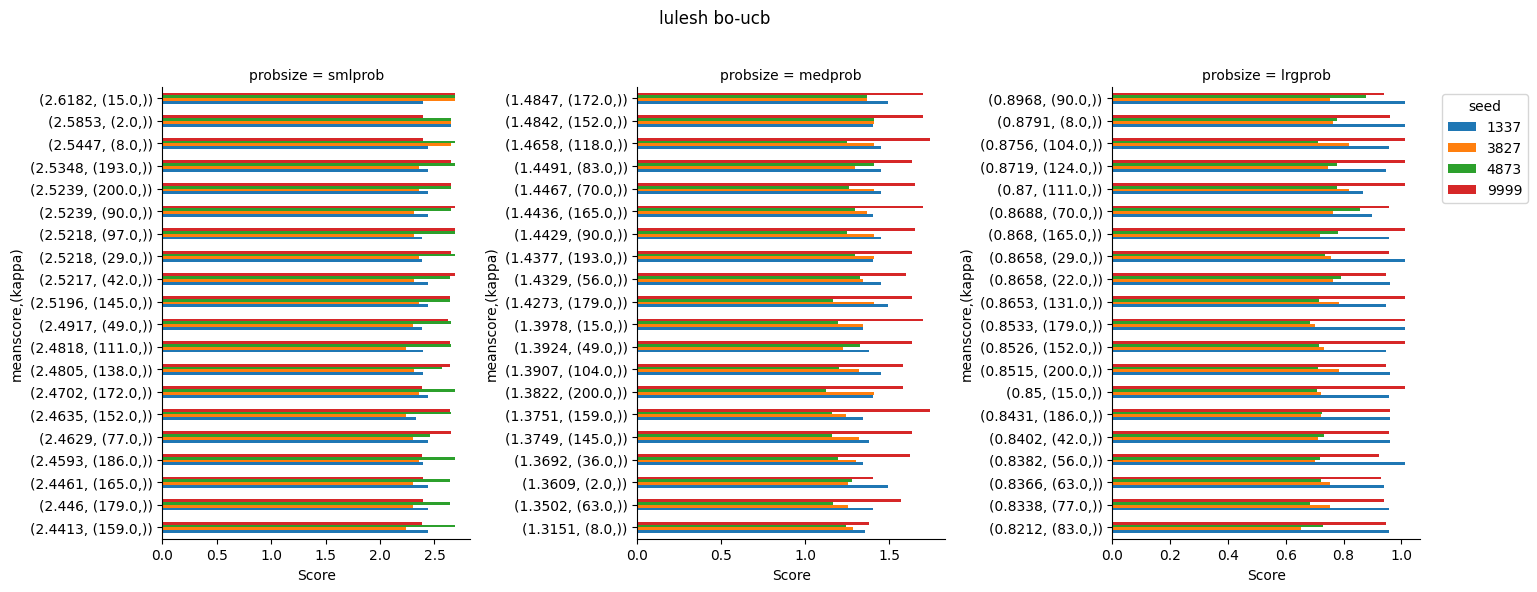

lulesh bo-ei 



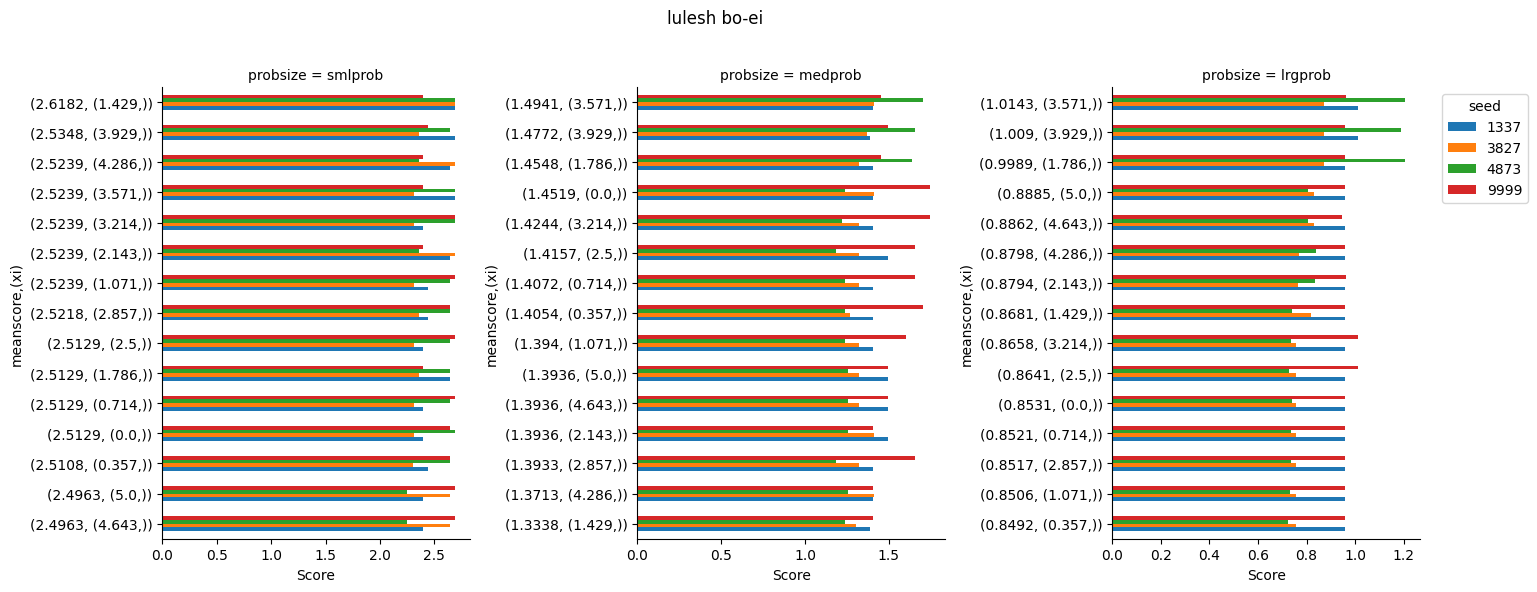

lulesh bo-poi 



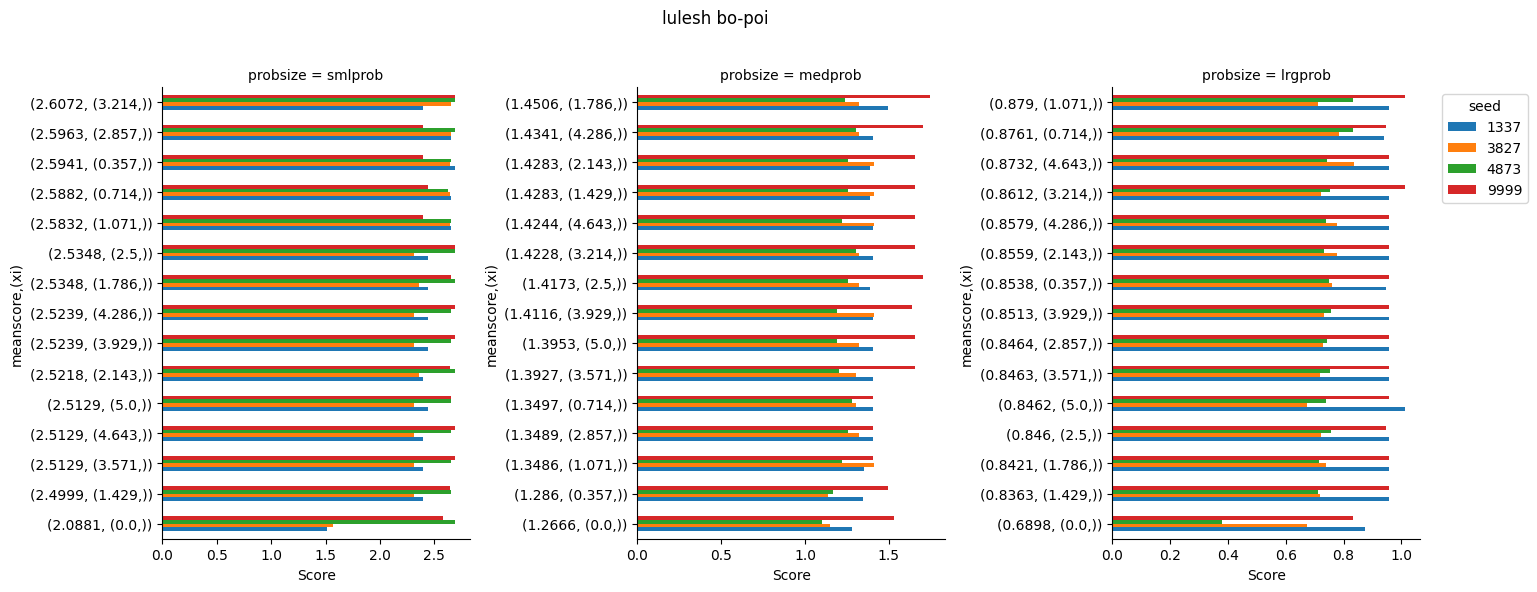

In [66]:
plotTopPoints(overallDF, 'bt_nas')
plotTopPoints(overallDF, 'hpcg')
plotTopPoints(overallDF, 'ft_nas')
plotTopPoints(overallDF, 'lulesh')